## Website Landing Page EDA, Statistical Analysis and Conversion Prediction

### Description of data  
Source Dataset: https://github.com/jainds/eda-for-conversion-rate-dataset/tree/master  

- "conversion_data" - information about signed-in users during one session. Each row is a user session.
- *country* : user country based on the IP address
- *age* : user age. Self-reported at sign-in step
- *new_user* : whether the user created the account during this session or had already an account and simply came back to the site
- *source* : marketing channel source
    - *Ads*: came to the site by clicking on an advertisement
    - *Seo*: came to the site by clicking on search results
    - *Direct*: came to the site by directly typing the URL on the browser
- *total_pages_visited*: number of total pages visited during the session (proxy for time spent on site and engagement during the session).
- *converted*: this is our label. 1 means they converted within the session, 0 means they left without buying anything.

### Objective
- Conduct an Exploratory Data Analysis (Data cleaning & prep, Uni/Bivariate Analysis, Conversion Rate Analysis)
- Statistical Testing to assess variables impacting Conversion Rate, Relationships among Variables 
- A/B Testing to assess impact of change in Landing Page (using artifically generated experiment vs. control group data)
- Development of an ML Classification model to predict Conversion of User, achieving at least 85% F1 Score.


### Initiation

In [67]:
# Import libraries

# Basic Data Imports
import numpy as np
import pandas as pd
import datetime as dt 

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Imports for stats
from scipy.stats import spearmanr


In [68]:
# Import dataset

df_original= pd.read_csv('data/conversion_data.csv')
df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [69]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


- Total 316,200 records, none of the columns have null values.
- No changes needed in data type.

In [70]:
df_original.describe(include= 'all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Initial Observations:
- Our dataset is derived from 4 countries, with most of the data being from US (more than 50%).
- Average age of visitors is ~ 31 years. Maximum age is 123 years, which looks like an outlier. Will check for outlying values.
- *new_user* being 1 implies they created an account when they visited the website in that instance. Average value of 0.68 indicates generally we might have more new users than old users.
- We have 3 channels identified as source (already defined in data description). ~50% of the visitors are coming from search results, and are in majority.
- Average page visits by users = 4.87. Maximum page visits by a user in a session is 29.
- *converted* would imply sale/conversion in that particular record/session. Average value of 0.0322 implies about 3.22% aggregate conversion rate. 


### Exploratory Data Analysis (EDA)
We'll follow the workflow below:
- Data Cleaning & Preparation, Check for missing values, duplicates and outliers.
- *Univariate Analysis*: 
    - Examine distributions of numerical variables (histograms for age, pages visited, etc.).
    - Review frequency counts for categorical variables (country, acquisition channel).
- *Bivariate Analysis*:
    - Use correlation matrices for numeric features (Age/Pages visited).
    - Country/Age, New User, Source, Mktg. Channel, Page visits
    - Age/New User, Source, Page Visits
    - New User/Source, Page visits
    - Source/Page Visits 
- *Deriving Conversion Rate*:
    - Calculate Agg. Conversion Rate (No. of Conversions/Total Sessions)
    - *Segmented rates*: conversion rates by category (e.g., by country, device type).

#### Data Cleaning

In [71]:
# Already checked in DF info that we don't have null values.
# Checking for duplicates

df_original.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


As the variables contain information about the demographic, marketing channel and general stats, there are likely to be duplications, considering we don't have any Personal Information to differentiate user session by any identity or specific location/time etc.  

Hence in this case, we will not be removing any duplicate records. We have already reviewed under the dataframe info that none of the columns have missing values.

In [72]:
df_original.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

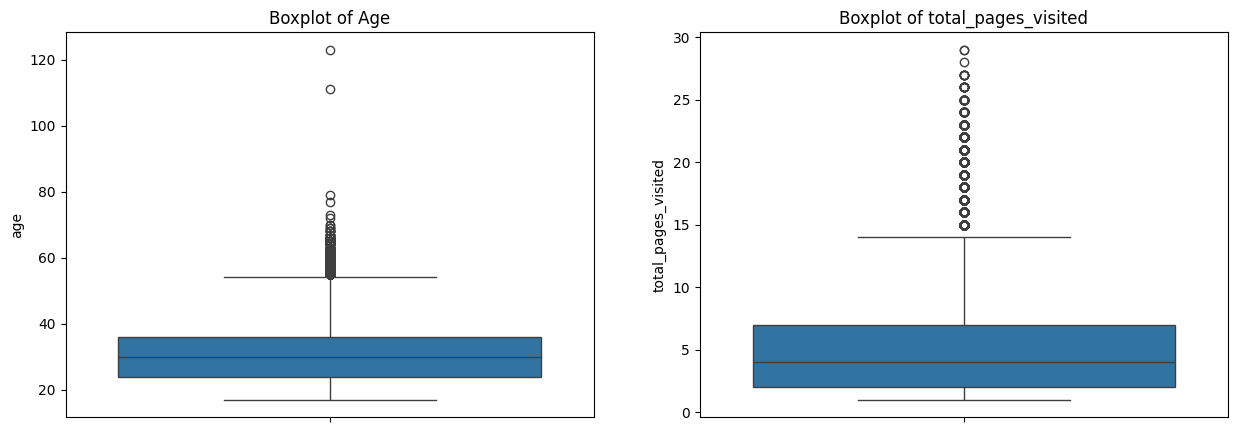

In [73]:
# Plotting boxplot to assess outliers in continuous variables age and total_pages_visited 
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.boxplot(df_original['age'],ax= axes[0])
ax1.set_title('Boxplot of Age')

ax2= sns.boxplot(df_original['total_pages_visited'],ax= axes[1])
ax2.set_title('Boxplot of total_pages_visited')

plt.show()

- 'Age' has quite a few extreme outliers. We also have values greater than 100, which we'll look into. Outliers might need to be dealt with for some modeling uses.
- 'total_pages_visited' is less skewed and there are some outlying values.
- We'll consider necessary action based on future needs.

In [74]:
df_original[df_original['age'] >100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [75]:
df_original.sort_values(by= ['age'], ascending= False).head()

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1
265167,US,79,1,Direct,1,0
192644,US,77,0,Direct,4,0
154217,US,73,1,Seo,5,0


There are 2 sessions, wherein the visitor age is above 100, which seems an erroneous value. As these are just 2 session records, we'll leave them as it is, given it wouldn't impact much.

In [76]:
# Creating a derived DF with renamed columns for simplicity
df_edit= df_original.rename(columns= {'total_pages_visited':'page_visits', 'source':'channel'})
df_edit.head()

,country,age,new_user,channel,page_visits,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


#### Univariate Analysis 

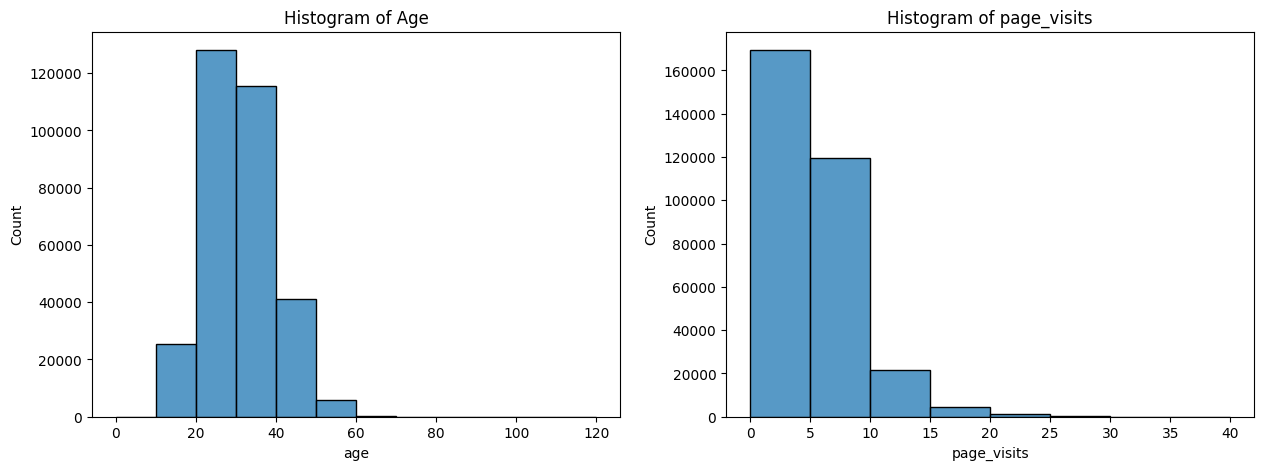

In [77]:
# Plotting histogram to review distribution of discrete variables
fig, axes = plt.subplots(1,2, figsize= (15,5))
ax1= sns.histplot(df_edit['age'], binwidth= 10, binrange= (0,120), ax= axes[0])
ax1.set_title('Histogram of Age')

ax2= sns.histplot(df_edit['page_visits'], binwidth= 5, binrange= (0,40), ax= axes[1])
ax2.set_title('Histogram of page_visits')

plt.show()

In [78]:
# Summary Statistics:
print('Five Number Summary - Age:-')
print('Minimum age:', df_edit['age'].min())
print('Lower Quartile:', df_edit['age'].quantile(0.25))
print('Median:', df_edit['age'].median())
print('Upper Quartile:', df_edit['age'].quantile(0.75))
print('Maximum age:', df_edit['age'].max())

print()
print('Five Number Summary - page_visits:-')
print('Minimum visits:', df_edit['page_visits'].min())
print('Lower Quartile:', df_edit['page_visits'].quantile(0.25))
print('Median:', df_edit['page_visits'].median())
print('Upper Quartile:', df_edit['page_visits'].quantile(0.75))
print('Maximum visits:', df_edit['page_visits'].max())


Five Number Summary - Age:-
Minimum age: 17
Lower Quartile: 24.0
Median: 30.0
Upper Quartile: 36.0
Maximum age: 123

Five Number Summary - page_visits:-
Minimum visits: 1
Lower Quartile: 2.0
Median: 4.0
Upper Quartile: 7.0
Maximum visits: 29


- Most visitors are between the age of 20-30 (more than 120K). 
- Most visitors are viewing between 0-5 pages on the website.
- Most visitors are aged 30 and visit 4 pages.
- Both distributions are skewed to the right.

In [79]:
# Review frequency counts for categorical variables (country, acquisition channel)

print(df_edit['country'].value_counts())
print()
print(df_edit['new_user'].value_counts())
print()
print(df_edit['channel'].value_counts())
print()
print(df_edit['converted'].value_counts())

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

new_user
1    216744
0     99456
Name: count, dtype: int64

channel
Seo       155040
Ads        88740
Direct     72420
Name: count, dtype: int64

converted
0    306000
1     10200
Name: count, dtype: int64


For our target variable, we have ~3% values as converted. There is a high *Class Imbalance* here, and if we do not get satisfactory performance from our models, we may try *Class Balancing*.

#### Bivariate Analysis

##### Correlation between discrete variables

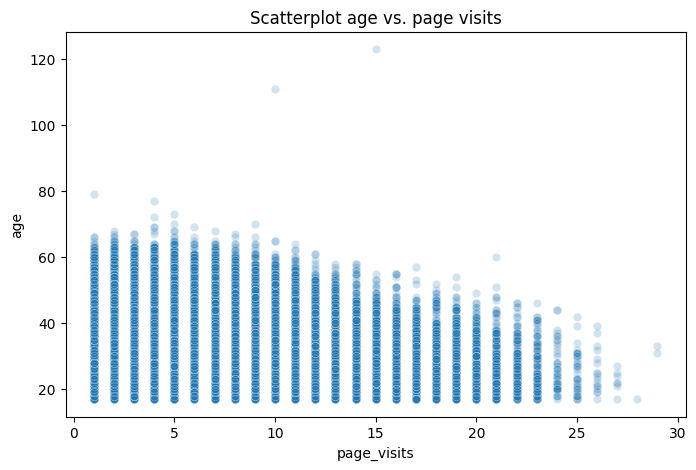

In [80]:
# Check correlation for numeric features (Age/Pages visited).
plt.figure(figsize= (8,5))
sns.scatterplot(y= df_edit['age'], x= df_edit['page_visits'], alpha= 0.2)
plt.title('Scatterplot age vs. page visits')
plt.show()

In [81]:
# Calculate Spearman's rank coefficient and p-value

rho, p_val = spearmanr(df_edit['age'],df_edit['page_visits'])

print("Spearman's rank correlation coefficient:", rho)
print("P-value:", p_val)

Spearman's rank correlation coefficient: -0.02610222876782161
P-value: 8.638578755890443e-49


There is almost no correlation between age and page visits. The statistical significance might be due to the large sample size.

##### Comparison by Market

In [ ]:
# Comparison of Average and Std. Deviation of Age, New User, Page Visits and Conversion by Country
df_edit.groupby(['country'])[['age','new_user','page_visits','converted']].agg(['mean','std']).style.background_gradient()

In [95]:
df_edit['country'].value_counts()

country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

*Observations*:
- Average age and distribution of website visitors is comparable across the 4 markets.
- *China*: Has highest %age of new users (69.85%), but the lowest conversion ratio ~1% and avg. page visits. They also have the second highest no. of sessions after US, so it might have a lot of potential and might be worth looking into. 
- *Germany*: Has lowest %age of new users (67.72%), but highest on avg. page visits and conversion ratio (~6.25%). It seems users are interested, but the low total no. of sessions suggest it might take some time to gather significance compared to other markets.

In [121]:
# Comparison of Sessions via Channels by Country
ctrychan_pivot= df_edit.pivot_table(index= 'country', columns= 'channel', aggfunc= 'size', fill_value= 0)
ctrychan_pivot['Ads_Cum'] = round((ctrychan_pivot['Ads']/ctrychan_pivot['Ads'].sum())*100,2)
ctrychan_pivot['Direct_Cum'] = round((ctrychan_pivot['Direct']/ctrychan_pivot['Direct'].sum())*100,2)
ctrychan_pivot['Seo_Cum'] = round((ctrychan_pivot['Seo']/ctrychan_pivot['Seo'].sum())*100,2)
ctrychan_pivot

channel,Ads,Direct,Seo,Ads_Cum,Direct_Cum,Seo_Cum
country,,,,,,
China,21561,17463,37578,24.30,24.11,24.24
Germany,3760,2864,6432,4.24,3.95,4.15
UK,13518,11131,23801,15.23,15.37,15.35
US,49901,40962,87229,56.23,56.56,56.26


- The 3 columns 'Ads_Cum', 'Direct_Cum' and 'Seo_Cum' represent the cumulative percentage of channel via which the session was reached from a particular country.
- There is no significant variance in distribution among the 3 countries, and regardless of the market, most sessions (~56%) are coming 

##### Comparison by Age

    - Age/New User, Source, Page Visits
    - New User/Source, Page visits
    - Source/Page Visits

### Statistical Testing
We'll follow the workflow below:
- Impact on Conversion by Country, Marketing Channel, New User (*Chi-Square Goodness of Fit*,*Two Sample Test of Proportion*)
- *Chi-Square Test for Independence*
    - Does Conversion for a Country get impacted by Marketing Channel, New User
    - Does Conversion for a Mktg. Channel get impacted by Country, New User
    - Does Conversion for a New User get impacted by Mktg. Channel, New User
- A/B Testing Simulation
    - Add variable for new page vs. old page (fictional)
    - Two sample test of Mean for performance of new v.s. old page

### Develop Machine Learning Classification Model
We'll follow the workflow below:
- Identify relevant variables for modeling based on Stats Testing.
- Design classification models using:
    - Logistic Regression
    - Naive Bayes
    - Random Forest with Cross Validation
    - XGBoost with Cross Validation
- Model Tuning and EDA




### Final Assessment, Summary and Recommendations